In [2]:
#-------- Import Libraries --------#

import torch
import time
import os
import sys
import random
import pickle
import mlflow
import gc
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sn
import matplotlib.pyplot as plt
from datetime import date
from sklearn.metrics import matthews_corrcoef
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

In [3]:
#-------- Import Modules from project--------#
import encoding as enc
from model import Net, Net_thesis, Net_project, Net_project2, Net_project3, Net_project4
import functions as func

In [4]:
#-------- Set Device --------#

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
else:
    print('No GPUs available. Using CPU instead.')
    device = torch.device('cpu')

No GPUs available. Using CPU instead.


In [5]:
#-------- Seeds --------#

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

torch.use_deterministic_algorithms(True)

In [6]:
#-------- Import Modules from project--------#

import encoding as enc
from model import Net_project, Net_project2, Net_project3, Net_project4
import functions as func

In [7]:
#-------- Import Dataset --------#             
#data_list = []
target_list = []

import glob
for index in range(4):
    for fp in glob.glob("../data/train/*{}*input.npz".format(index+1)):
        print("Read file", fp)
        data = np.load(fp)["arr_0"]
        targets = np.load(fp.replace("input", "labels"))["arr_0"]
        #data_list.append(data)
        target_list.append(targets)
    
for fp in glob.glob("../data/validation/*5*input.npz"):
    print("Read file", fp)
    data = np.load(fp)["arr_0"]
    targets = np.load(fp.replace("input", "labels"))["arr_0"]
    #data_list.append(data)
    target_list.append(targets)
    
print("\n")

print("target_list", len(target_list))

print("\n")

data_partitions = len(target_list)
for i in range(len(target_list)):
    print("Size of file", i+1, len(target_list[i]))

del data, targets
gc.collect()

Read file ../data/train/P1_input.npz
Read file ../data/train/P2_input.npz
Read file ../data/train/P3_input.npz
Read file ../data/train/P4_input.npz
Read file ../data/validation/P5_input.npz


data_list: 5
target_list 5


Size of file 1 1526
Size of file 2 1168
Size of file 3 1480
Size of file 4 1532
Size of file 5 1207


In [8]:
#-------- Select the network you would like to use -------#

modelName = "Net_project"
 
    
CNN = False # ONLY CNN
CNN_RNN = True # CNN + RNN

# Type of embedding
embedding = "esm-1b"   #"esm_ASM"
keep_energy = False

esm_1b_separated = True   ### update
if esm_1b_separated:       ### update
    keep_energy = False

# Hyperparameters to fine-tune
numHN = 26
numFilter = 100
dropOutRate = 0.3
learning_rate = 0.001
weight_decay = 0.0001

# For ml-flow
name_experiment = "testing different models"


##--- parameters fixed
cross_validation = False
bat_size = 128
num_classes=1
epochs = 100
patience=10
criterion = nn.BCEWithLogitsLoss()
    

In [9]:
# Loading model

if modelName == "Net_project":
    model = Net_project
elif modelName == "Net_project2":
    model = Net_project2
elif modelName == "Net_project3":
    model = Net_project3
elif modelName == "Net_project4":
    model = Net_project4

In [10]:
#embedding of data

#create directory to fetch/store embedded
embedding_dir= '../data/embeddedFiles/'
data_list_enc = list()

try:
    os.mkdir(embedding_dir)
except:
    pass


#try to fecth if already exist
if embedding == "Baseline":   
    #data_list_enc = data_list
    pass
else:
    try:
        for i in range(4):
            
            #infile = open(embedding_dir + 'esm-energies.pkl'.format(embedding), 'rb') ## format {} missing
            infile = open(embedding_dir + 'esm-energies-file-updated-{}.pkl'.format(i+1), 'rb')
            enc = pickle.load(infile)
            data_list_enc.append(enc)
            print("File", i+1, "is uploaded. Size:", len(enc))

            infile.close()
    except:
        print("embedded file not found")

del enc
gc.collect()

print("Done")

File 1 is uploaded. Size: 1532
File 2 is uploaded. Size: 1532
File 3 is uploaded. Size: 1532
File 4 is uploaded. Size: 1532
File 5 is uploaded. Size: 1532
Done


In [11]:
#-------- Print Dimentions -------#

print("Total number of files:", len(data_list_enc), "\n")

for i in range(len(data_list_enc)):
    print("File", i)
    print("number of complexes:", len(data_list_enc[i]))
    print("number of rows:", len(data_list_enc[i][0]))
    print("number of columns:", len(data_list_enc[i][0][0]))
    print("\n")

Total number of files: 5 

File 0
number of complexes: 100
number of rows: 420
number of columns: 1313


File 1
number of complexes: 100
number of rows: 420
number of columns: 1313


File 2
number of complexes: 100
number of rows: 420
number of columns: 1313


File 3
number of complexes: 100
number of rows: 420
number of columns: 1313


File 4
number of complexes: 100
number of rows: 420
number of columns: 1313




In [14]:
X_test = np.concatenate(data_list_enc[3:])
y_test = np.concatenate(target_list[3:])
nsamples, nx, ny = X_test.shape
print("Test set shape:", nsamples,nx,ny)

data_list_enc = data_list_enc[:4]
gc.collect()

X_valid = np.concatenate(data_list_enc[2:3])
y_valid = np.concatenate(target_list[2:3])
nsamples, nx, ny = X_valid.shape
print("Validation set shape:", nsamples,nx,ny)

data_list_enc = data_list_enc[:3]
gc.collect()

X_train = np.concatenate(data_list_enc[0:2])
y_train = np.concatenate(target_list[0:2])
nsamples, nx, ny = X_train.shape
print("Training set shape:", nsamples,nx,ny)

del data_list_enc
gc.collect()

# features and residues
features = list(range(ny))
residues = list(range(nx)) 
n_features = len(features)
input_size = len(residues)


test_ds = []
for i in range(len(X_test)):
    test_ds.append([np.transpose(X_test[i][:,features]), y_test[i]])

del X_test, y_test 
gc.collect()

# Dataloader
train_ds = []
for i in range(len(X_train)):
    train_ds.append([np.transpose(X_train[i][:,features]), y_train[i]])
    
del X_train, y_train 
gc.collect() 

val_ds = []
for i in range(len(X_valid)):
    val_ds.append([np.transpose(X_valid[i][:,features]), y_valid[i]])

    
    
train_ldr = torch.utils.data.DataLoader(train_ds,batch_size=bat_size, shuffle=True)
val_ldr = torch.utils.data.DataLoader(val_ds,batch_size=bat_size, shuffle=True)
test_ldr = torch.utils.data.DataLoader(test_ds,batch_size=len(test_ds), shuffle=True)




Training set shape: 300 420 1313
Validation set shape: 100 420 1313
Test set shape: 100 420 1313


0

In [15]:
###############################
###    CNN+RNN              ###
###############################
start = time.time()

if cross_validation == False:
    
    print("Parameters:")
    print("cross_validation", cross_validation)
    print("embedding", embedding)
    print("numHN", numHN)
    print("numFilter", numFilter)
    print("dropOutRate", dropOutRate)
    print("esm_1b_separated", esm_1b_separated)  ### update
    print("keep_energy", keep_energy)
    print("num_classes", num_classes)
    print("learning_rate", learning_rate)
    print("bat_size", bat_size)
    print("patience", patience)
    print("criterion", criterion)
    print("model", modelName )
    print("\n\n")
    
    #-------- Train --------#

    # Initialize network
    net = model(num_classes=num_classes, 
             n_features=n_features, 
             numHN=numHN, 
             numFilter=numFilter,
             dropOutRate=dropOutRate).to(device)
    
    optimizer = optim.Adam(net.parameters(), lr=learning_rate,
                           weight_decay=weight_decay,
                           amsgrad=True,)
    
    train_acc, train_losses, train_auc, valid_acc, valid_losses, valid_auc, val_preds, val_targs, test_preds, test_targs, test_loss, test_acc, test_auc = func.train_project(net, optimizer, train_ldr, val_ldr, test_ldr, X_valid, epochs, criterion, patience)

else:
    pass

print("Done in", round((time.time()-start)/60,2), "mins." )

print("test_acc, test_auc:")
print(test_acc[0], ",", test_auc[0])


Parameters:
cross_validation False
embedding esm-1b
numHN 26
numFilter 100
dropOutRate 0.3
esm_1b_separated True
keep_energy False
num_classes 1
learning_rate 0.001
bat_size 128
patience 10
criterion BCEWithLogitsLoss()



Epoch 0  	 Train loss: 0.00676 	 Validation loss: 0.00688
Epoch 5  	 Train loss: 0.00644 	 Validation loss: 0.00672
Epoch 10  	 Train loss: 0.00470 	 Validation loss: 0.00454
Epoch 15  	 Train loss: 0.00348 	 Validation loss: 0.00368
Epoch 20  	 Train loss: 0.00334 	 Validation loss: 0.00441
Epoch 25  	 Train loss: 0.00274 	 Validation loss: 0.00368
Epoch 30  	 Train loss: 0.00213 	 Validation loss: 0.00625
Epoch 35  	 Train loss: 0.00261 	 Validation loss: 0.00314
Epoch 40  	 Train loss: 0.00186 	 Validation loss: 0.00200
Epoch 45  	 Train loss: 0.00229 	 Validation loss: 0.00341
Early stopping

0
Done in 7.25 mins.
test_acc, test_auc:
0.96 , 0.9579655317360234


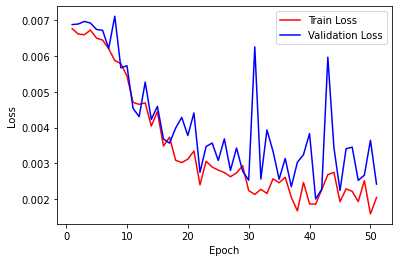

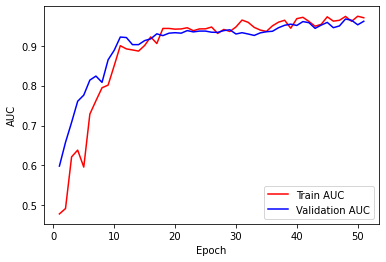

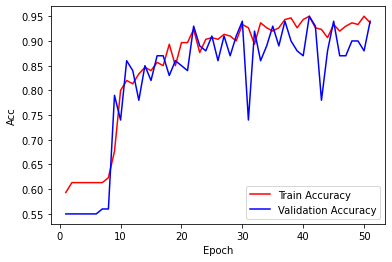

AUC:  0.9579655317360234
MCC:  0.9159310634720471


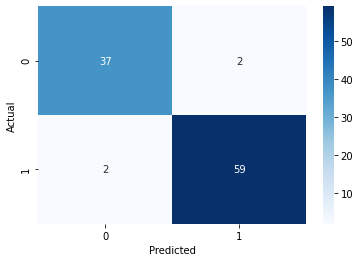

AUC: 0.958
4


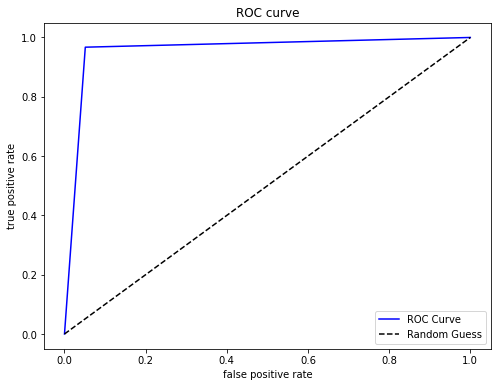

AUC:  0.9579655317360234
MCC:  0.9159310634720471
ACC:  0.96


In [16]:
#-------- Performance --------#

epoch = np.arange(1,len(train_losses)+1)
plt.figure()
plt.plot(epoch, train_losses, 'r', epoch, valid_losses, 'b')
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Epoch'), plt.ylabel('Loss')

epoch = np.arange(1,len(train_auc)+1)
plt.figure()
plt.plot(epoch, train_auc, 'r', epoch, valid_auc, 'b')
plt.legend(['Train AUC','Validation AUC'])
plt.xlabel('Epoch'), plt.ylabel('AUC')

epoch = np.arange(1,len(train_acc)+1)
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.xlabel('Epoch'), plt.ylabel('Acc')
plt.show()


#-------- Save results --------#

results_dir = '../results'

try:
    os.mkdir(results_dir)
except:
    pass

plots_dir = '../results/plots'

try:
    os.mkdir(plots_dir)
except:
    pass

results = pd.DataFrame(list(zip( (int(x) for x in test_targs), (int(x) for x in test_preds))),columns =['target', 'pred'])

#print(results)
results.to_csv('../results/models_{}_targets_vs_preds_emb_{}_HN_{}_nFilt_{}_do_{}_.csv'.format(modelName, embedding,numHN,numFilter,int(dropOutRate*10)), index=False)


#-------- Performance Evaluation --------#
# The results change every time we train, we should check why (maybe we missed something or did wrong with the seeds?)

print("AUC: ", roc_auc_score(results['target'], results['pred']))
print("MCC: ", matthews_corrcoef(results['target'], results['pred']))

confusion_matrix = pd.crosstab(results['target'], results['pred'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.show()

# Plot roc curve

fpr, tpr, thres = roc_curve(results['target'], results['pred'])
print('AUC: {:.3f}'.format(roc_auc_score(results['target'], results['pred'])))

print( len([i for i, (a, b) in enumerate(zip(results['pred'], results['target'])) if a != b]))

plt.figure(figsize=(8,6))

# roc curve
plt.plot(fpr, tpr, "b", label='ROC Curve')
plt.plot([0,1],[0,1], "k--", label='Random Guess')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")

plt.savefig('../results/plots/models_{}_targets_vs_preds_emb_{}_HN_{}_nFilt_{}_do_{}_ROC.png'.format(modelName, embedding,numHN,numFilter,int(dropOutRate*10)))
plt.show()

AUC = roc_auc_score(results['target'], results['pred'])
MCC = matthews_corrcoef(results['target'], results['pred'])
ACC = accuracy_score(results['target'], results['pred'])
print("AUC: ", AUC)
print("MCC: ", MCC)
print("ACC: ", ACC)

In [18]:
#storing values
import mlflow
import mlflow.sklearn

#exp = mlflow.set_experiment(name_experiment)
#experiment = mlflow.get_experiment(exp.experiment_id)

experiment_id = mlflow.set_experiment(name_experiment)
experiment = mlflow.get_experiment(experiment_id.experiment_id)

#print("Name: {}".format(experiment.name))
#print("Experiment_id: {}".format(experiment.experiment_id))
#print("Artifact Location: {}".format(experiment.artifact_location))

with mlflow.start_run():
    mlflow.log_param('embedding', embedding)
    mlflow.log_param('model', modelName) 
    
    mlflow.log_param('esm_1b_separated', str(esm_1b_separated)) ### update
    
    mlflow.log_param('Hidden Neurons', numHN)
    mlflow.log_param('filters CNN', numFilter)
    mlflow.log_param('Dropout rate', dropOutRate)
    mlflow.log_param('learning rate', learning_rate)
    mlflow.log_param('Weight decay', weight_decay)
    
    mlflow.log_metric('test AUC', AUC)
    mlflow.log_metric('test MCC', MCC)
    mlflow.log_metric('test ACC', ACC)
    
    mlflow.log_metric('train ACC', train_acc[-1])
    mlflow.log_metric('train AUC', train_auc[-1])
    mlflow.log_metric('valid ACC', valid_acc[-1])
    mlflow.log_metric('valid AUC', valid_auc[-1])

from csv import writer


print("\n")
print('embedding', embedding) 
print('model', modelName)
print('Hidden Neurons', numHN)
print('filters CNN', numFilter)
print('Dropout rate', dropOutRate)
print('learning rate', learning_rate)
print('Weight decay', weight_decay)

print('test AUC', AUC)
print('test MCC', MCC)
print('test ACC', ACC)

print('train ACC', train_acc[-1])
print('train AUC', train_auc[-1])
print('valid ACC', valid_acc[-1])
print('valid AUC', valid_auc[-1])


#List = ['embedding', 'numHN', 'numFilter', 'dropOutRate', 'learning_rate', 'weight_decay', 'AUC', 'MCC', 'ACC', 'train_acc', 'train_auc', 'valid_acc', 'valid_auc' ]
List = [embedding, modelName, numHN, numFilter, dropOutRate, learning_rate, weight_decay, AUC, MCC, ACC, train_acc[-1], train_auc[-1], valid_acc[-1], valid_auc[-1] ]

with open('../results/improve_network_metrics.csv', 'a') as f_object:
    writer_object = writer(f_object)
  
    writer_object.writerow(List)
  
    f_object.close()

Name: Default
Experiment_id: 0
Artifact Location: file:///home/shannara/DL_02456/dayana_run/scripts/mlruns/0


embedding esm-1b
model Net_project
esm_1b_separated True
Hidden Neurons 26
filters CNN 100
Dropout rate 0.3
learning rate 0.001
Weight decay 0.0001
test AUC 0.9579655317360234
test MCC 0.9159310634720471
test ACC 0.96
train ACC 0.9366666666666666
train AUC 0.9699681409295352
valid ACC 0.94
valid AUC 0.9612121212121212
